<a href="https://colab.research.google.com/github/Ray3104/Autonomous-vehicle-assignment/blob/main/lab2_task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Task 2:**
The car speed is set to 1.0 in the original program. Setting a higher speed may cause the car to
lose control, as shown in the following visualization of the actual trajectory for speed of 10.0,
obtained with plt.plot() (you may or may not get the exact same result).

**********************************************************************************

Final parameters:  [0.9, 0, 0.0]

Error:  487927.8676378622
**********************************************************************************

Final parameters:  [1.9, 0, 0.0]

Error:  688215.5350304324
**********************************************************************************

Final parameters:  [-0.10000000000000009, 0, 0.0]

Error:  1050255.0988172337
**********************************************************************************

Final parameters:  [0.8999999999999999, 1.0, 0.0]

Error:  44460.78999717269
**********************************************************************************

Final parameters:  [0.8999999999999999, 1.0, 1.0]

Error:  755543.9875255255
**********************************************************************************

Final parameters:  [0.8999999999999999, 1.0, -1.0]

Error:  1279829.0364990185
*****************************************************************

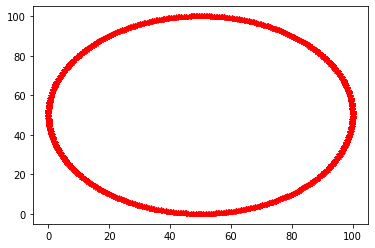

**********************************************************************************

Final parameters:  [0.0011227509848979467, 0.08558244476425383, 0.0007178979876918401]

Error:  9.425436313325484e-25


In [ ]:
# --------------
# User Instructions
# 
# Finish the PID in the run function 
#
#
# --------------
# PID Control Racetrack
# speed = 10.0
# dt = 1

 
from math import *
import random
import matplotlib.pyplot as plt

# ------------------------------------------------
# 
# this is the robot class
#

class robot:

    # --------
    # init: 
    #    creates robot and initializes location/orientation to 0, 0, 0
    #

    def __init__(self, length = 20.0):
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    # --------
    # set: 
    #	sets a robot coordinate
    #

    def set(self, new_x, new_y, new_orientation):

        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation) % (2.0 * pi)


    # --------
    # set_noise: 
    #	sets the noise parameters
    #

    def set_noise(self, new_s_noise, new_d_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = float(new_s_noise)
        self.distance_noise = float(new_d_noise)

    # --------
    # set_steering_drift: 
    #	sets the systematical steering drift parameter
    #

    def set_steering_drift(self, drift):
        self.steering_drift = drift
        
    # --------
    # move: 
    #    steering = front wheel steering angle, limited by max_steering_angle
    #    distance = total distance driven, most be non-negative

    def move(self, steering, distance, 
             tolerance = 0.001, max_steering_angle = pi / 4.0):

        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0


        # make a new copy
        res = robot()
        res.length         = self.length
        res.steering_noise = self.steering_noise
        res.distance_noise = self.distance_noise
        res.steering_drift = self.steering_drift

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = tan(steering2) * distance2 / res.length

        if abs(turn) < tolerance:

            # approximate by straight line motion

            res.x = self.x + (distance2 * cos(self.orientation))
            res.y = self.y + (distance2 * sin(self.orientation))
            res.orientation = (self.orientation + turn) % (2.0 * pi)

        else:

            # approximate bicycle model for motion

            radius = distance2 / turn
            cx = self.x - (sin(self.orientation) * radius)
            cy = self.y + (cos(self.orientation) * radius)
            res.orientation = (self.orientation + turn) % (2.0 * pi)
            res.x = cx + (sin(res.orientation) * radius)
            res.y = cy - (cos(res.orientation) * radius)

        return res

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]'  % (self.x, self.y, self.orientation)
   
    def cte(self, radius):           
        center = [radius, radius] #y,x           
        cte = ((self.x - center[1])**2 + (self.y - center[0])**2)**0.5 - radius
        return cte
 
# ------------------------------------------------------------------------
#
# run - does a single control run.


def run(params, radius, printflag = False):
    myrobot = robot()
    myrobot.set(0.0, radius, pi / 2.0)
    speed = 10.0 # motion distance is equal to speed (we assume time = 1)
    err = 0.0
    int_crosstrack_error = 0.0
    N =1000
    crosstrack_error = myrobot.cte(radius)
    x_trajectory = []
    y_trajectory = []
    for i in range(N*2):
        diff_crosstrack_error = - crosstrack_error
        crosstrack_error = myrobot.cte(radius)
        diff_crosstrack_error += crosstrack_error
        int_crosstrack_error += crosstrack_error
        steer = -params[0] * crosstrack_error - params[1] * diff_crosstrack_error - params[2] * int_crosstrack_error
        myrobot = myrobot.move(steer, speed)

        if i >= N:
            err += crosstrack_error ** 2
            x_trajectory.append(myrobot.x)
            y_trajectory.append(myrobot.y)
        if printflag:
            print (myrobot)
    if printflag:
      plt.plot(x_trajectory,y_trajectory, color="r", linestyle="--", marker="*", linewidth=1.0)
      plt.show()
    print('**********************************************************************************')
    print('\nFinal parameters: ', params)
    print('\nError: ', err)
    return err / float(N)  

def twiddle(radius,tol=0.2):  
    
    # modified twiddle: PID controller 
    p = [0.9, 0, 0.0]
    dp = [1.0, 1.0, 1.0]
    best_err = run(p, radius)
    it = 0
    while sum(dp) > tol:
        # print("Iteration {}, best error = {}".format(it, best_err))
        for i in range(len(p)):
            p[i] += dp[i]
            err = run(p, radius)
            if err < best_err:
                best_err = err
                dp[i] *= 1.1
            else:
                p[i] -= 2 * dp[i]
                err = run(p, radius)
                if err < best_err:
                    best_err = err
                    dp[i] *= 1.1
                else:
                    p[i] += dp[i]
                    dp[i] *= 0.9
        it += 1
    return p, best_err


radius = 50.0
#params = [10.0, 15.0, 0]
params,err = twiddle(radius)
err = run(params, radius,True)

**********************************************************************************

Final parameters:  [0.9, 0, 0.0]

Final dt 3.4469990327749765e-91

Error:  1800.1325766342045
**********************************************************************************

Final parameters:  [1.9, 0, 0.0]

Final dt 3.4469990327749765e-91

Error:  1800.1325766342045
**********************************************************************************

Final parameters:  [-0.10000000000000009, 0, 0.0]

Final dt 3.394504347331852e-92

Error:  1341390.8691878724
**********************************************************************************

Final parameters:  [0.8999999999999999, 1.0, 0.0]

Final dt 0.2058911320946491

Error:  176.05803043864012
**********************************************************************************

Final parameters:  [0.8999999999999999, 1.0, 1.0]

Final dt 9.735343390770922e-92

Error:  48023.57004487568
******************************************************************

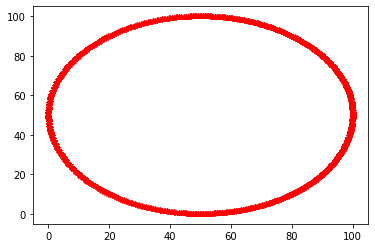

**********************************************************************************

Final parameters:  [2.3577759, 2.7723264097774627, 0.5904900000000004]

Final dt 0.07976644307687257

Error:  8.138520186984135e-26


In [ ]:
# --------------
# User Instructions
# 
# Finish the PID in the run function 
#
#
# --------------
# PID Control Racetrack
# variable dt

 
from math import *
import random
import matplotlib.pyplot as plt

# ------------------------------------------------
# 
# this is the robot class
#

class robot:

    # --------
    # init: 
    #    creates robot and initializes location/orientation to 0, 0, 0
    #

    def __init__(self, length = 20.0):
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    # --------
    # set: 
    #	sets a robot coordinate
    #

    def set(self, new_x, new_y, new_orientation):

        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation) % (2.0 * pi)


    # --------
    # set_noise: 
    #	sets the noise parameters
    #

    def set_noise(self, new_s_noise, new_d_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = float(new_s_noise)
        self.distance_noise = float(new_d_noise)

    # --------
    # set_steering_drift: 
    #	sets the systematical steering drift parameter
    #

    def set_steering_drift(self, drift):
        self.steering_drift = drift
        
    # --------
    # move: 
    #    steering = front wheel steering angle, limited by max_steering_angle
    #    distance = total distance driven, most be non-negative

    def move(self, steering, distance, 
             tolerance = 0.001, max_steering_angle = pi / 4.0):
        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0

        # make a new copy
        res = robot()
        res.length         = self.length
        res.steering_noise = self.steering_noise
        res.distance_noise = self.distance_noise
        res.steering_drift = self.steering_drift

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = tan(steering2) * distance2 / res.length

        if abs(turn) < tolerance:

            # approximate by straight line motion

            res.x = self.x + (distance2 * cos(self.orientation))
            res.y = self.y + (distance2 * sin(self.orientation))
            res.orientation = (self.orientation + turn) % (2.0 * pi)

        else:

            # approximate bicycle model for motion

            radius = distance2 / turn
            cx = self.x - (sin(self.orientation) * radius)
            cy = self.y + (cos(self.orientation) * radius)
            res.orientation = (self.orientation + turn) % (2.0 * pi)
            res.x = cx + (sin(res.orientation) * radius)
            res.y = cy - (cos(res.orientation) * radius)

        return res

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]'  % (self.x, self.y, self.orientation)
   
    def cte(self, radius):           
        center = [radius, radius] #y,x           
        cte = ((self.x - center[1])**2 + (self.y - center[0])**2)**0.5 - radius
        return cte
 
# ------------------------------------------------------------------------
#
# run - does a single control run.


def run(params, radius, printflag = False):
    myrobot = robot()
    myrobot.set(0.0, radius, pi / 2.0)
    speed = 10.0 # motion distance is equal to speed (we assume time = 1)
    err = 0.0
    int_crosstrack_error = 0.0
    N =1000
    dt = 1
    crosstrack_error = myrobot.cte(radius)
    x_trajectory = []
    y_trajectory = []
    for i in range(N*2):
        diff_crosstrack_error = - crosstrack_error
        crosstrack_error = myrobot.cte(radius)
        diff_crosstrack_error += crosstrack_error
        diff_crosstrack_error = diff_crosstrack_error/dt
        int_crosstrack_error += crosstrack_error*dt
        steer = -params[0] * crosstrack_error - params[1] * diff_crosstrack_error - params[2] * int_crosstrack_error
        if steer > 0:
          dt *= 0.9
        else:
          dt = dt
        myrobot = myrobot.move(steer, speed*dt)

        if i >= N:
            err += crosstrack_error ** 2
            x_trajectory.append(myrobot.x)
            y_trajectory.append(myrobot.y)
        if printflag:
            print (myrobot)
    if printflag:
      plt.plot(x_trajectory,y_trajectory, color="r", linestyle="--", marker="*", linewidth=1.0)
      plt.show()
    print('**********************************************************************************')
    print('\nFinal parameters: ', params)
    print('\nFinal dt', dt)
    print('\nError: ', err)
    return err / float(N)  

def twiddle(radius,tol=0.2):  
    
    # modified twiddle: PID controller 
    p = [0.9, 0, 0.0]
    dp = [1.0, 1.0, 1.0]
    best_err = run(p, radius)
    it = 0
    while sum(dp) > tol:
        # print("Iteration {}, best error = {}".format(it, best_err))
        for i in range(len(p)):
            p[i] += dp[i]
            err = run(p, radius)
            if err < best_err:
                best_err = err
                dp[i] *= 1.1
            else:
                p[i] -= 2 * dp[i]
                err = run(p, radius)
                if err < best_err:
                    best_err = err
                    dp[i] *= 1.1
                else:
                    p[i] += dp[i]
                    dp[i] *= 0.9
        it += 1
    return p, best_err


radius = 50.0
#params = [10.0, 15.0, 0]
params,err = twiddle(radius)
err = run(params, radius,True)